Assignment 1: SMS Spam Case-Study
=================================

This notebook is separated into the following sections:

1. Data Loading and Preprocessing
2. Splitting Data
3. k-NN Preprocessing
4. k-NN Model Testing
5. k-NN Test Result Analysis
6. Naive Bayes Model Training
7. Naive Bayes Test Result Analysis
8. Execution

The first seven sections only contain library imports, function definitions, and constant declarations. The code cells in these sections can be executed easily with the "Run cells above" feature, and should take only a few seconds to execute.

The Execution section contains the code cells that will actually execute the functions in the proper order. Please pay attention to the comments in these code cells before executing them, and in particular the code cells that start with `%%time`, since some of them can take a long time to execute.

Specifically, the cells that perform k-NN tests for all odd k-values between 1 and 101 can take multiple hours, and are generally not necessary to execute. They are included for the sake of completeness.

In [2]:
# Standard library imports
from collections import Counter
import multiprocessing
import os
import pprint
import string
from string import punctuation

# External library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configure Matplotlib
%matplotlib inline
plt.style.use("ggplot")

# Data Loading and Preprocessing

In [3]:
import hashlib
import io
from zipfile import ZipFile

import requests

def download_dataset():
    """Download the dataset, extract it, and put it in a pandas DataFrame.

    This function will download and extract the dataset into memory, which is
    acceptable since the decompressed dataset is approximately 450 KiB. It will
    also verify the SHA-256 hash of the dataset.

    :returns: The DataFrame containing the dataset, or None if the dataset was
        corrupted. The type will be stored in the 'Type' column, and the raw
        SMS message will be stored in the 'SMS_Content' column.
    """
    # Download the compressed dataset from UC Irvine's ML Repository
    # https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
    resp = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip")

    # Extract the dataset into memory
    # Extracted dataset is approx. 450 KiB
    with io.BytesIO(resp.content) as zipped_bytes:
        with ZipFile(zipped_bytes) as zf:
            with zf.open("SMSSpamCollection") as unzipped_bytes:
                dataset = io.BytesIO(unzipped_bytes.read())

    # Verify that the dataset wasn't corrupted
    VALID_DATASET_HASH = "7d039a24a6083ed9ef0f806ebad56bbb976e3aeb8de05669173bfdc4996c239d"
    if hashlib.sha256(dataset.getbuffer()).hexdigest() != VALID_DATASET_HASH:
        print("Dataset is corrupt! Try to download again, or find a different source.")
        return None

    # Load the data from the TSV file
    dataset.seek(0)
    df = pd.read_table(dataset, sep="\t", names=["Type", "SMS_Content"])
    return df

In [4]:
def convert_type(df):
    """Convert the categorical variable 'Type' into a numerical variable.

    "Spam" is the positive class, so the type will be converted as follows:
        spam = 1
        ham = 0

    :param df: A DataFrame containing the original dataset.
    :return: A modified DataFrame where the 'Type' column in 
    """
    df["Type"] = (df["Type"] == "spam").astype(np.int)
    return df

In [5]:
import nltk

def init_nltk():
    """Download the NLTK English-language stopword list."""
    try:
        nltk.data.find("stopwords")
    except LookupError:
        nltk.download("stopwords")

In [6]:
from nltk.corpus import stopwords

def preprocessing(data):
    """Perform a few data preprocessing methods to a raw SMS message.

    This function should be called by passing it as the only argument to the
    .apply() function of the pandas DataFrame column that is to be
    preprocessed.

    The following preprocessing methods will be applied, in order:
    1. Lowercase all words
    2. Tokenize the message by splitting it on whitespace
    3. Remove any stopwords in the data
    4. Remove all punctuation

    :param data: A single data point in the dataset.
    """
    en_stopwords = stopwords.words("english")

    # Lowercase and tokenize the message
    data = data.lower().split()

    # Remove stopwords
    no_stopwords = []
    for word in data:
        if word not in en_stopwords:
            no_stopwords.append(word)

    # Remove all punctuation
    # Untokenize the data so removing punctuation uses one loop instead of two
    data = " ".join(no_stopwords)
    for punct in list(punctuation):
        data = data.replace(punct, "")

    # Retokenize the data
    return data.split()

In [7]:
def apply_preprocessing(df):
    """Apply data preprocessing to a DataFrame containing the dataset.

    The new dataset will contain the following columns:
    Type - a numerical variable representing whether the message is spam or ham
    SMS_Tokens - a list of preprocessed words in the SMS message

    :param df: A DataFrame containing the raw dataset.
    :returns: A DataFrame containing the preprocessed dataset.
    """
    df = convert_type(df)
    init_nltk()
    df["SMS_Tokens"] = df.SMS_Content.apply(preprocessing)
    return df.drop("SMS_Content", axis=1)

# Splitting Data

In [8]:
def partition(data, labels, ratio):
    """Partition the data into training and testing datasets.

    :param data: A numpy array of all datapoints in the dataset.
    :param labels: A numpy array of the labels associated with the datapoints,
        in the same order.
    :param ratio: The proportion of the dataset that should be set aside for
        testing.
    :return: The data and labels split into training and testing datasets.
    """
    datapoints = len(data)
    test_indexes = np.random.randint(0, datapoints, int(ratio * datapoints))
    test_data = []
    train_data = []
    test_labels = []
    train_labels = []
    for i in range(datapoints):
        if i in test_indexes:
            test_data.append(data[i])
            test_labels.append(labels[i])
        else:
            train_data.append(data[i])
            train_labels.append(labels[i])

    return np.array(train_data), np.array(test_data), np.array(train_labels), np.array(test_labels)

# K-NN Preproccessing

In [9]:
def term_frequencies(message):
    """Calculate the term frequency (TF) of each word in a message.

    TF = (# times word W is in the message) / (total words in the message)
    
    :param message: An SMS message, split into a list of words and
        preprocessed.
    :return: A dictionary that maps the words in the message to their TFs.
    """
    # Store the TFs in a map of Word-to-TF. We will later add the columns once we know all words in the corpus.
    word_map = {}

    for word in message:
        if word in word_map:
            word_map[word] += 1
        else:
            word_map[word] = 1

    for word in word_map.keys():
        word_map[word] = word_map[word] / len(message)

    return word_map

In [10]:
from math import log

def document_frequencies(messages):
    """Calculate the inverse document frequency (IDF) for each word in the
    dataset.

    IDF = log(total messages / # of messages with word W)

    :param messages: A list of tokenized, preprocessed SMS messages.
    :return: A dictionary that maps the words in the dataset to their IDFs.
    """
    # Count how many messages each word appears in
    word_to_message_count = {}
    for message in messages:
        unique_words = set(message)
        for word in unique_words:
            if word in word_to_message_count:
                word_to_message_count[word] += 1
            else:
                word_to_message_count[word] = 1

    # Store the IDFs in a map of Word-to-IDF
    idf_map = {}
    for word in word_to_message_count.keys():
        idf_map[word] = log(len(messages) / word_to_message_count[word])

    return idf_map

In [11]:
def calculate_tf_idfs(tf_maps, idfs, unique_words):
    """Calculate the TF-IDFs for each row in the dataset.

    Example structure of the return type:
                   "hello" "world" "ml"
    message_1  [ [ TF-IDF, TF-IDF, TF-IDF ],
    message_2    [ TF-IDF, TF-IDF, TF-IDF ],
    message_3    [ TF-IDF, TF-IDF, TF-IDF ] ]

    :param tf_maps: A list of word-to-TF mappings for each row in the dataset.
    :param idfs: A word-to-IDF mapping that contains all words in the training
        dataset.
    :param unique_words: A list of all the unique words in the dataset.
    :return: A two-dimensional list that contains all rows in the dataset,
        where each row is a list containing the TF-IDF values for that message
        of each word in the training dataset.
    """
    tf_idfs = []
    for tf_map in tf_maps:
        new_row = []

        for word in unique_words:
            word_tf = tf_map.get(word, 0)
            new_row.append(word_tf * idfs[word])

        tf_idfs.append(new_row)

    return tf_idfs

In [12]:
def get_tf_idf_dataframe(data, training_idfs, unique_words):
    """Create a DataFrame containing the TF-IDFs for each message in the
    dataset.
    
    The new DataFrame will contain a column for each unique word in the
    training dataset. Each row will contain the TF-IDFs for each of those words
    for a specific message.

    :param data: The dataset to calculate TF-IDFs for.
    :param training_idfs: The IDFs calculated from the training dataset.
    :param unique_words: A list of all the unique words in the training
        dataset.
    :return: A DataFrame containing the TF-IDFs for each message in the
        dataset.
    """
    with multiprocessing.pool.Pool(multiprocessing.cpu_count()) as pool:
        tfs = pool.map(term_frequencies, data)

    tf_idfs = calculate_tf_idfs(tfs, training_idfs, unique_words)
    tf_idf_table = pd.DataFrame(tf_idfs, columns=unique_words)

    return tf_idf_table

# k-NN Model Testing

In [13]:
def euclidean(train_row, observation):
    """Calculate the Euclidean distance between two datapoints.

    :param train_row: A datapoint in the training dataset.
    :param observation: A datapoint in the testing dataset.
    :return: The Euclidean distance between the two datapoints.
    """
    total_distance = np.sum((train_row - observation) ** 2)
    return np.sqrt(total_distance)

In [14]:
def manhattan(train_row, observation):
    """Calculate the Manhattan distance between two datapoints.

    :param train_row: A datapoint in the training dataset.
    :param observation: A datapoint in the testing dataset.
    :return: The Manhattan distance between the two datapoints.
    """
    total_distance = np.sum(abs(train_row - observation)) 
    return total_distance

In [15]:
def knn_predict(k, train, observation, training_labels, distance_func):
    """Predict whether an observed datapoint is spam or ham using k-NN.

    :param k: The k-value to use for k-NN.
    :param train: A DataFrame containing the TF-IDF values for the training
        dataset.
    :param observation: A row from the TF-IDF DataFrame for the testing
        dataset. The spam/ham prediction will be made for this datapoint.
    :param training_labels: A numpy array of the labels for the training data.
        Must be in the same order as the rows of the `train` DataFrame.
    :param distance_func: The distance function to use for computing distance
        between datapoints. Must take two equal-length numpy arrays as
        positional arguments.
    :returns: True if the datapoint is predicted spam, False if the datapoint
        is predicted ham.
    """
    # Convert the observation row to a numpy array so it can be passed to the distance function
    observation_np = observation.to_numpy()

    # Determine the distance between the observed data point and every data point in the training data.
    distances = []
    for trainrow_idx, trainrow in train.iterrows():
        distance = distance_func(trainrow.to_numpy(), observation_np)
        distances.append((distance, trainrow_idx))

    # Determine which class is more popular within the K nearest neighbors
    distances.sort()
    spam_count = 0
    ham_count = 0
    for distance, trainrow_idx in distances[:k]:
        label = training_labels[trainrow_idx]
        if label == 1:
            spam_count += 1
        else:
            ham_count += 1

    return spam_count > ham_count

In [16]:
def knn_worker(args):
    """A helper function to simplify calling knn_predict() function by using
    the map() function of multiprocessing pools.

    This is a gross way of passing multiple arguments through multiprocessing,
    but I prefer it to using the shared variable constructs available.

    The `args` tuple should contain the following content at each index:
    0 - An item from pandas.DataFrame.iterrows(). The index will be discarded.
    1 - The k-value to use.
    2 - The distance function to use.
    3 - The DataFrame containing the TF-IDF values for the training dataset.
    4 - A numpy array containing the labels for the training dataset.

    :param args: A tuple containing the arguments for knn_predict.
    :returns: The results of the knn_predict() call.
    """
    _, row = args[0]
    k = args[1]
    distance_func = args[2]
    train_tf_idfs = args[3]
    train_labels = args[4]
    return knn_predict(k, train_tf_idfs, row, train_labels, distance_func)

In [17]:
def run_knn_test(pool, test_dataframe, k_values, distance_func, train_data, train_labels):
    """Run the k-NN classifier against the test dataset for each odd-numbered
    k-value within the provided range.

    :param pool: A multiprocessing pool to run the test in.
    :param test_dataframe: A DataFrame containing the TF-IDF values for the
        test dataset.
    :param k_values: The K values to attempt.
    :param distance_func: The distance function to use for the test.
    :param train_data: A DataFrame containing the TF-IDF values for the
        training dataset.
    :param train_labels: A numpy array containing the labels for the training
        dataset.
    :returns: A list of tuples describing the results. Each tuple will contain
        the k-value used, followed by a list of the predictions that were made.
    """
    # Try each odd-numbered K value in the range
    results = []
    for k in k_values:
        test_datapoints = len(test_dataframe.index)

        # Create the iterators for the arguments to the knn_worker() function.
        ks = [k] * test_datapoints
        funcs = [distance_func] * test_datapoints
        tdatas = [train_data] * test_datapoints
        tlabels = [train_labels] * test_datapoints

        # Assemble the arguments for the knn_worker() function
        args = zip(test_dataframe.iterrows(), ks, funcs, tdatas, tlabels)

        # Run the test
        predictions = pool.map(knn_worker, args)
        results.append((k, predictions))

    return results


# k-NN Test Result Analysis

In [18]:
# The list of columns that a metrics DataFrame will contain
METRICS_COLUMNS = [
    "X Axis", # If k-NN, this is the K-Value. If Naive Bayes, this is always zero.
    "True Positives",
    "False Positives",
    "True Negatives",
    "False Negatives",
    "Accuracy",
    "Precision",
    "Recall",
]

In [19]:
def get_knn_test_metrics(results, actuals):
    """Calculate the metrics for each (k-value, predictions) result returned by
    the run_knn_test() function.

    :param results: A return value from run_knn_test.
    :param actuals: The labels for the training data.
    :returns: A DataFrame that contains metrics for the k-NN test runs found in
        the results list.
    """
    # Calculate the metrics for each test run found in the results
    metric_data = []
    for k, predictions in results:
        # Calculate the confusion matrix
        true_pos = false_pos = true_neg = false_neg  = 0
        for idx, prediction in enumerate(predictions):
            actual = actuals[idx]

            if prediction == 1 and actual == 1:
                true_pos += 1
        
            if prediction == 1 and actual == 0:
                false_pos += 1

            if prediction == 0 and actual == 0:
                true_neg += 1
            
            if prediction == 0 and actual == 1:
                false_neg += 1
        
        # Calculate the accuracy, precision, and recall
        accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)
        try:
            precision = true_pos / (true_pos + false_pos)
        except ZeroDivisionError:
            precision = 0
        try:
            recall = true_pos / (true_pos + false_neg)
        except ZeroDivisionError:
            precision = 0

        metric_data.append([k, true_pos, false_pos, true_neg, false_neg, accuracy, precision, recall])

    return pd.DataFrame(metric_data, columns=METRICS_COLUMNS)

# Naive Bayes Model Training

In [20]:
def train_model(train_data, train_labels, unique_words, alpha):
    """Count how many times each word appears in the spam and ham messages of
    the training dataset.

    The return value has the following structure:
    {
        word 1: [count_given_spam, count_given_ham],
        word 2: [count_given_spam, count_given_ham],
    }

    :param train_data: A list of tokenized, preprocessed messages.
    :param train_labels: A list of spam/ham labels for the data.
    :param unique_words: A list of all words that occur in the data.
    :param alpha: The alpha value to use.
    :returns: A mapping of words to counts.
    """
    # the map for the number of spam and ham messages of each word
    counts_map = {}
    spam_words_count = 0
    ham_words_count = 0
    for idx, row in enumerate(train_data):
        if train_labels[idx] == 1:  # get label from Y
            spam_words_count += len(row)
            for word in row:
                if word in counts_map:
                    counts_map[word][0] += 1
                else:
                    counts_map[word] = [1 + alpha, 0 + alpha]
        else:
            ham_words_count += len(row)
            for word in row:
                if word in counts_map:
                    counts_map[word][1] += 1
                else:
                    counts_map[word] = [0 + alpha, 1 + alpha]

    return counts_map, spam_words_count, ham_words_count

In [21]:
def spam_detector(counts_map, message, prob_spam, prob_ham, spam_count, ham_count, alpha):
    """Predicts whether or not a message is spam.

    :param counts_map: A mapping of words to counts. See the return value of
        train_model().
    :param message: The message to make a prediction for.
    :param prob_spam: The overall probability that a message is spam.
    :param prob_ham: The overall probability that a message is ham.
    :param spam_count: The number of words in spam messages in the training
        dataset.
    :param ham_count: The number of words in ham messages in the training
        dataset.
    :param alpha: The alpha value to use.
    :returns: True if the message is predicted spam, False if the message is
        predicted ham.
    """
    probability_spam = 0.0
    probability_ham = 0.0
    for idx, word in enumerate(message):
        counts = counts_map.get(word, [alpha, alpha])

        # Calculate probability of spam
        count_given_spam = counts[0]
        probability_spam += log(count_given_spam / spam_count)

        # Calculate probability of ham
        count_given_ham = counts[1]
        probability_ham += log(count_given_ham / ham_count)

    probability_spam += log(prob_spam)
    probability_ham += log(prob_ham)
    return probability_spam > probability_ham

# Naive Bayes Test Result Analysis

In [22]:
def run_naive_bayes_test(test_data, counts_map, spam_count, ham_count, alpha): 
    """Run Naive Bayes against the testing dataset.

    :param test_data: The testing dataset.
    :param counts_M
    :param counts_map: A mapping of words to counts. See the return value of
        train_model().
    :param spam_count: The number of words in spam messages in the training
        dataset.
    :param ham_count: The number of words ham messages in the training
        dataset.
    :param alpha: The alpha value to use.
    :returns: A list of predictions from spam_detector().
    """
    total_count = ham_count + spam_count
    predictions = []
    for idx, row in enumerate(test_data):
        is_spam = spam_detector(counts_map, row, spam_count/total_count, ham_count/total_count, spam_count, ham_count, alpha)
        predictions.append(is_spam)

    return predictions

In [23]:
def get_test_nb_metrics(predicted_values, actuals):
    """Calculate the metrics for the predicted values returned by the
    run_naive_bayes_test() function.

    :param predicted_values: A return value from run_naive_bayes_test.
    :param actuals: The labels for the training data.
    :returns: A DataFrame that contains metrics for the Naive Bayes test.
    """
    metric_data = []

    # Calculate the metrics for each test run found in the results
    # Calculate the confusion 
    true_pos = false_pos = true_neg = false_neg  = 0
    for idx, prediction in enumerate(predictions):
        actual = actuals[idx]

        if prediction == 1 and actual == 1:
            true_pos += 1
    
        if prediction == 1 and actual == 0:
            false_pos += 1

        if prediction == 0 and actual == 0:
            true_neg += 1
        
        if prediction == 0 and actual == 1:
            false_neg += 1

    accuracy = (true_pos + true_neg) / (true_pos + false_pos + true_neg + false_neg)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)

    metric_data.append([0, true_pos, false_pos, true_neg, false_neg, accuracy, precision, recall])

    return pd.DataFrame(metric_data, columns=METRICS_COLUMNS)

In [24]:
def display_metrics_scatterplot(metrics, title):
    """Display the metrics in a scatterplot form.
    
    :param metrics: A metrics dataframe returned by a get_*_metrics
        function.
    :param title: The title for the graph.
    """
    sns.scatterplot(metrics["X Axis"], metrics["Accuracy"], label="Accuracy")
    sns.scatterplot(metrics["X Axis"], metrics["Precision"], label="Precision")
    sns.scatterplot(metrics["X Axis"], metrics["Recall"], label="Recall")
    plt.title(title)
    plt.ylabel("Percentage")
    plt.show()

# Execution

In [25]:
%%time
# This block took approximately 20 seconds in testing.

# Download and preprocess the data
dataframe = download_dataset()
dataframe = apply_preprocessing(dataframe)

# Split the data into training and testing
data = dataframe["SMS_Tokens"].to_numpy()
labels = dataframe["Type"].to_numpy()
train_data, test_data, train_labels, test_labels = partition(data, labels, 0.2)

# Get the TF-IDFs for the data
idfs = document_frequencies(train_data)
unique_terms = list(idfs.keys())
train_tf_idfs = get_tf_idf_dataframe(train_data, idfs, unique_terms)
test_tf_idfs = get_tf_idf_dataframe(test_data, idfs, unique_terms)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
CPU times: user 18 s, sys: 2.11 s, total: 20.1 s
Wall time: 21.6 s


In [26]:
# Create the multiprocessing pool.
# Run this before testing k-NN.
cpus = multiprocessing.cpu_count()
pool = multiprocessing.Pool(cpus)

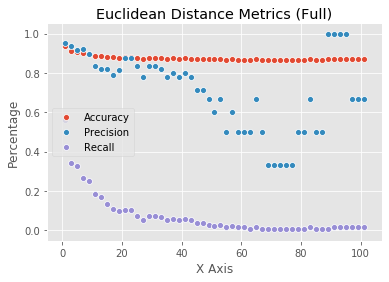

CPU times: user 22min 41s, sys: 41min 55s, total: 1h 4min 37s
Wall time: 1h 30min 37s


In [26]:
%%time
# Run k-NN for all odd k-values between 1 and 101.
# WARNING: THIS MAY TAKE SEVERAL HOURS.
euclidean_full = run_knn_test(pool, test_tf_idfs, range(1, 103, 2), euclidean, train_tf_idfs, train_labels)

# Calculate and display the metrics
euclidean_full_metrics = get_knn_test_metrics(euclidean_full, test_labels)
display_metrics_scatterplot(euclidean_full_metrics, "Euclidean Distance Metrics (Full)")

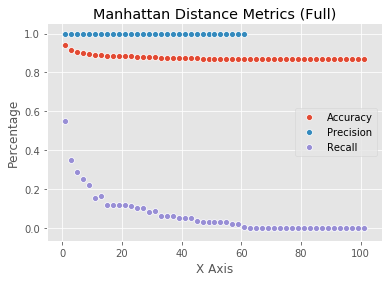

CPU times: user 22min 32s, sys: 41min 21s, total: 1h 3min 53s
Wall time: 1h 29min 37s


In [27]:
%%time
# Run k-NN for all odd k-values between 1 and 101.
# WARNING: THIS MAY TAKE SEVERAL HOURS.
manhattan_full = run_knn_test(pool, test_tf_idfs, range(1, 103, 2), manhattan, train_tf_idfs, train_labels)

# Calculate and display the metrics
manhattan_full_metrics = get_knn_test_metrics(manhattan_full, test_labels)
display_metrics_scatterplot(manhattan_full_metrics, "Manhattan Distance Metrics (Full)")

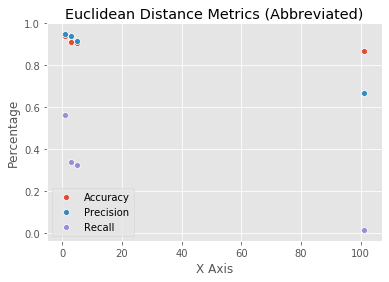

CPU times: user 1min 46s, sys: 3min 15s, total: 5min 1s
Wall time: 7min 2s


,X Axis,True Positives,False Positives,True Negatives,False Negatives,Accuracy,Precision,Recall
0,1,76,4,881,59,0.938235,0.950000,0.562963
1,3,46,3,882,89,0.909804,0.938776,0.340741
2,5,44,4,881,91,0.906863,0.916667,0.325926
3,101,2,1,884,133,0.868627,0.666667,0.014815


In [28]:
%%time
# Run k-NN for all k-values 1, 3, 5, and 101.
# WARNING: This may take several minutes.
euclidean_short = run_knn_test(pool, test_tf_idfs, [1, 3, 5, 101], euclidean, train_tf_idfs, train_labels)

# Calculate and display the metrics
euclidean_short_metrics = get_knn_test_metrics(euclidean_short, test_labels)
display_metrics_scatterplot(euclidean_short_metrics,  "Euclidean Distance Metrics (Abbreviated)")

# Also display the dataframe for the report
euclidean_short_metrics

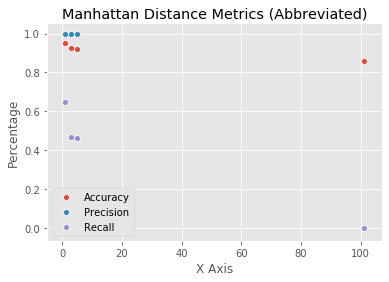

CPU times: user 1min 44s, sys: 3min 14s, total: 4min 59s
Wall time: 6min 58s


,X Axis,True Positives,False Positives,True Negatives,False Negatives,Accuracy,Precision,Recall
0,1,94,0,870,51,0.949754,1.0,0.648276
1,3,68,0,870,77,0.924138,1.0,0.468966
2,5,67,0,870,78,0.923153,1.0,0.462069
3,101,0,0,870,145,0.857143,0.0,0.000000


In [27]:
%%time
# Run k-NN for all k-values 1, 3, 5, and 101.
# WARNING: This may take several minutes.
manhattan_short = run_knn_test(pool, test_tf_idfs, [1, 3, 5, 101], manhattan, train_tf_idfs, train_labels)

# Calculate and display the metrics
manhattan_short_metrics = get_knn_test_metrics(manhattan_short, test_labels)
display_metrics_scatterplot(manhattan_short_metrics, "Manhattan Distance Metrics (Abbreviated)")

# Also display the dataframe for the report
manhattan_short_metrics

In [28]:
# Clean up the multiprocessing pool.
# Run this after you're done testing k-NN.
pool.close()
pool.join()

In [31]:
# Pick the alpha value that will be used
alpha = 0.0001

# Train the Naive Bayes model
counts_map, spam_words, ham_words = train_model(train_data, train_labels, unique_terms, alpha)

In [32]:
%%time
# Test the Naive Bayes model
predictions = run_naive_bayes_test(test_data, counts_map, spam_words, ham_words, alpha) 

CPU times: user 16 ms, sys: 3.57 ms, total: 19.5 ms
Wall time: 19.3 ms


In [33]:
# Calculate and view metrics
prediction_metrics = get_test_nb_metrics(predictions, test_labels)
prediction_metrics

,X Axis,True Positives,False Positives,True Negatives,False Negatives,Accuracy,Precision,Recall
0,0,134,20,850,11,0.969458,0.87013,0.924138
